In [1]:
import torch
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader


import torch.nn as nn

import matplotlib.pyplot as plt

import importlib
if importlib.util.find_spec('ipywidgets') is not None:
    from tqdm.auto import tqdm
else:
    from tqdm import tqdm

#import networkx as nx

from typing import Union

In [2]:
dataframe = pd.read_csv('C:\\Users\Cristiane\Documents\\UFMG\Arquivos_Dissertacao\Projeto\data\\final_novo.csv', sep=';')

dataframe = dataframe.drop(['Chave'], axis=1)
dataframe = dataframe.fillna(-1) #todo -1
dataframe['Anos educacao formal'] = dataframe['Anos educacao formal'].replace(-5, -1)
dataframe['sexo'].replace({'M': 0, 'F': 1}, inplace=True)
df_suic = dataframe.copy()
df_suic = df_suic.astype(float)
df_suic.shape

(3953, 68)

In [40]:
df_suic['Estudante'].loc[(df_suic.Estudante==0.9)] =1.0
df_suic['Estudante'].loc[(df_suic.Estudante==0.8)] =1.0
df_suic['Estudante'].loc[(df_suic.Estudante==0.6)] =1.0
df_suic['Estudante'].loc[(df_suic.Estudante==0.4)] =0.0
df_suic['Estudante'].loc[(df_suic.Estudante==0.5)] =1.0
df_suic['Trabalho e interesses'].loc[(df_suic['Trabalho e interesses']==-2)] =0.0
df_suic['Trabalho e interesses'].unique()

array([ 2.,  3.,  4.,  0.,  1., -1.])

In [41]:
df_suic.loc[(df_suic.Suic_familia==1)&
(df_suic["Capaz de tomar decisões importantes"]==1)&
(df_suic["Estudante"]==1)&
(df_suic["Hipocondriase"]==0)&
(df_suic["Sentimentos_culpa"]==2)&
(df_suic["Trabalho e interesses"]==2)&
(df_suic["Dep_familia"]==1)&
(df_suic["Alc_familia"]==1)&
(df_suic["Capaz de desfrutar das coisas"]==1)&
(df_suic["Droga"]==0)&
(df_suic["Suicidio"]==1)&
(df_suic["Ansiedade"]==2)]

,sexo,Estado_civil,Status_empl,Licenca,Tipo_Resid,Residencia,Alcoolatra,Droga,Suic_familia,Dep_familia,...,Eixo I: Panico sem agorafobia,Eixo I: Fobia especifica,Eixo I: Fobia social,Eixo I: Obsessivo-compulsivo,Eixo I: Estresse pos-traumatico,Eixo I: Ansiedade generalizada,Eixo II: Personalidade paranoica,Eixo II: Transtorno de personalidade,TOC,idade
615,-1.0,5.0,3.0,0.0,4.0,3.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
831,0.0,1.0,4.0,0.0,1.0,-1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.0
2449,1.0,5.0,4.0,0.0,2.0,3.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
2507,1.0,1.0,4.0,0.0,4.0,3.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,20.0
3319,0.0,1.0,4.0,0.0,4.0,3.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
3524,1.0,1.0,1.0,0.0,4.0,3.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0


In [42]:
#df_suic['Suicidio']=np.where((df_suic['Suicidio'] >1),1.0,0.0)
#df_suic['Ansiedade']=np.where((df_suic['Ansiedade'] >1),1.0,0.0)

In [43]:
notears_selected = [
   "Suic_familia",
    "Capaz de tomar decisões importantes",
    "Estudante",
    "Hipocondriase",
    "Sentimentos_culpa",
    "Trabalho e interesses",
    'Dep_familia',
    'Alc_familia',
    'Capaz de desfrutar das coisas',
    'Droga',
    'Suicidio',
    'Ansiedade'
     ]

# Create datasets

The first one is normal and the second has the graph structur

In [44]:
def adj_to_edge_index(adj):
    edge_index = []
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            edge_index.append([i, j])
    return torch.tensor(edge_index, dtype=torch.float).t().contiguous()

# Dataset from X 
class CausalDataset(Dataset):
    def __init__(self, X, target:Union[list, int]):
        self.X = torch.tensor(X, dtype=torch.double)
        self.target = target
        if isinstance(target, int):
            self.target = [target]
        

        # X is every variable except the target list
        dims = list(range(self.X.shape[1]))
        self.x = self.X[:, [i for i in dims if i not in self.target]]
        self.y = self.X[:, self.target]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].double(), self.y[idx].double()

#from torch_geometric.data import Data



# Create Models

In [45]:
#from torch_geometric.nn import models as GeometricModels

# Create a MLP that takes as input a list of dimensions
class MLP(torch.nn.Module):
    def __init__(self, dim_list:list, add_dropout:bool=False):
        super(MLP, self).__init__()
        torch.manual_seed(3)
        self.layers = torch.nn.ModuleList()
        for i in range(len(dim_list) - 2):
            self.layers.append(torch.nn.Linear(dim_list[i], dim_list[i+1]))
            self.layers.append(torch.nn.ReLU())
            if add_dropout:
                self.layers.append(torch.nn.Dropout(0.3))

        self.layers.append(torch.nn.Linear(dim_list[-2], dim_list[-1]))
        self.double()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x



# Out train pipeline

In [46]:
def trainPipeline(dataset, model, batch_size=64, train_split=0.8, verbose=True, max_epochs=100, patience=10, lr=0.001, weight_decay=0.0, loss_fn=nn.MSELoss()):
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    torch.manual_seed(3)
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    criterion = loss_fn
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    patience = patience

    train_losses = []
    test_losses = []
    for epoch in tqdm(range(max_epochs)):
        train_loss = 0
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        test_loss = 0
        model.eval()
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        if verbose:
            print(f"Epoch {epoch} - Train loss: {train_loss} - Test loss: {test_loss}")

        # add early stopping with patience variable
        if epoch > 10:
            all_patience = test_losses[-patience:]
            test_loss = test_losses[-1]
            if all([test_loss > x for x in all_patience]):
                print("Early stopping")
                break


    # test model on test set and calculate accuracy
    model.eval()
    with torch.no_grad():
        y_pred_test = []
        y_true_test = []
        y_pred_train = []
        y_true_train = []

        for data, target in train_loader:
            output = model(data)
            y_pred_train.append(output)
            y_true_train.append(target)
        for data, target in test_loader:
            output = model(data)
            y_pred_test.append(output)
            y_true_test.append(target)

        y_pred_test = torch.cat(y_pred_test, dim=0)
        y_true_test = torch.cat(y_true_test, dim=0)
        y_pred_train = torch.cat(y_pred_train, dim=0)
        y_true_train = torch.cat(y_true_train, dim=0)

        train_error = torch.abs(y_pred_train - y_true_train)
        test_error = torch.abs(y_pred_test - y_true_test)

        # calculate accuracy for each target
        test_accuracy = []
        train_accuracy = []
        for i in range(len(y_true_test[0])):
            test_accuracy.append(torch.sum(test_error[:, i] < 0.5) / len(test_error))
            train_accuracy.append(torch.sum(train_error[:, i] < 0.5) / len(train_error))      

        print(f"Final Train accuracy: {train_accuracy}")
        print(f"Final Test accuracy: {test_accuracy}")      

    metrics = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_error": train_error,
        "test_error": test_error,
        "test_accuracy": test_accuracy
    }

    return model, metrics


# Now we train the conterfactual net without causal features selecion

  0%|          | 0/300 [00:00<?, ?it/s]

Final Train accuracy: [tensor(0.6695)]
Final Test accuracy: [tensor(0.6625)]


  0%|          | 0/300 [00:00<?, ?it/s]

Final Train accuracy: [tensor(0.7302)]
Final Test accuracy: [tensor(0.7042)]


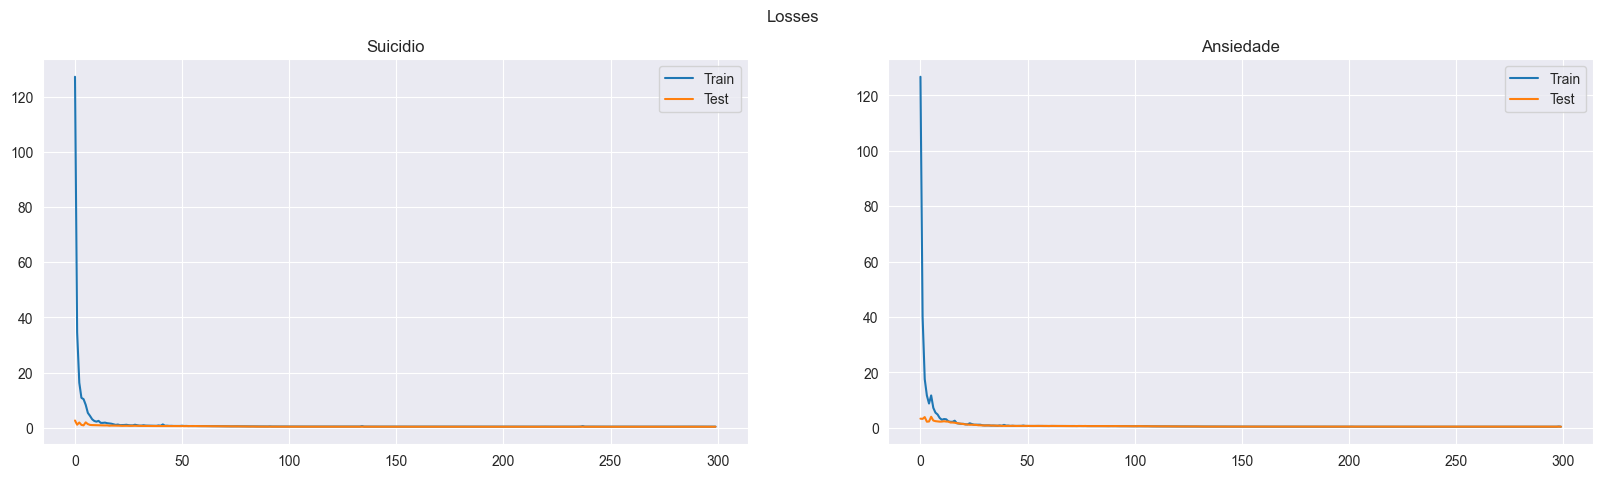

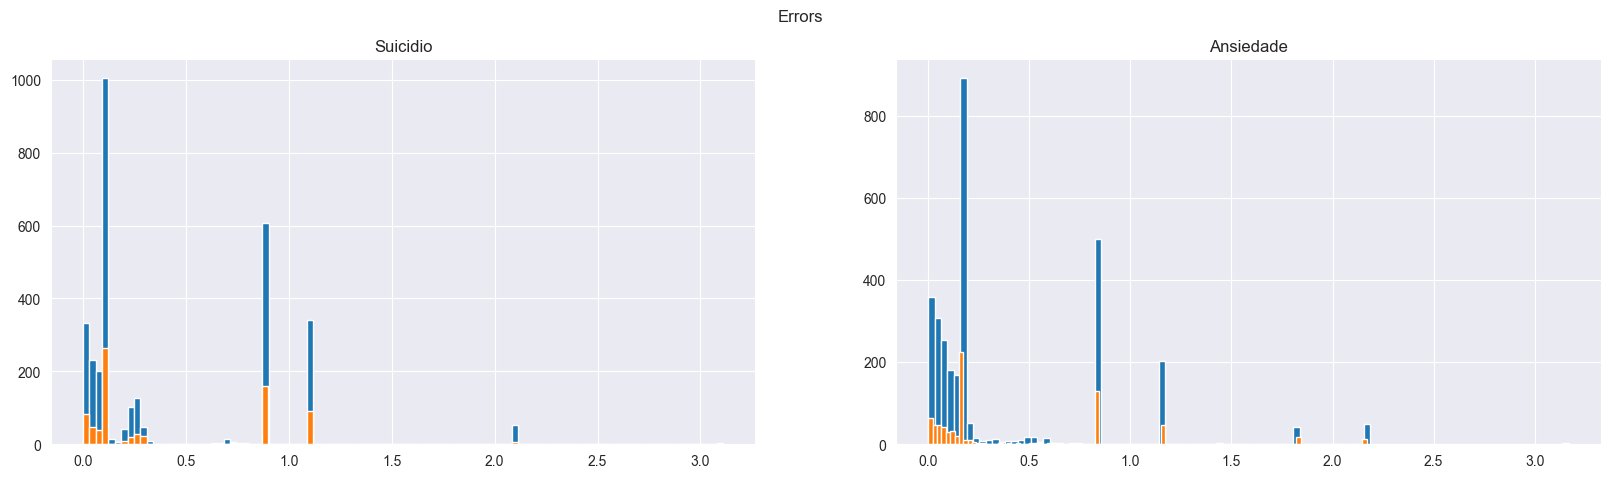

In [47]:
# get the target collumns indexes
targets = ["Suicidio", "Ansiedade"]
targets_idx = [df_suic.columns.get_loc(c) for c in targets]

# Create the dataset
suic_dataset = CausalDataset(df_suic.values, targets_idx[0])
anx_dataset = CausalDataset(df_suic.values, targets_idx[1])
sample_x, sample_y = suic_dataset[0]

# Now we predict the first target with a MLP
suic_model = MLP([sample_x.shape[0], 64, 64, 64, 1], add_dropout=True)
anx_model = MLP([sample_x.shape[0], 64, 64, 64, 1], add_dropout=True)

suic_model, suic_metrics = trainPipeline(suic_dataset, suic_model, verbose=False, max_epochs=300, weight_decay=1e-5)
anx_model, anx_metrics = trainPipeline(anx_dataset, anx_model, verbose=False, max_epochs=300, weight_decay=1e-5)

# plot the losses with subplots todo
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Losses")
axs[0].plot(suic_metrics["train_loss"], label="Train")
axs[0].plot(suic_metrics["test_loss"], label="Test")
axs[0].set_title("Suicidio")
axs[0].legend()

axs[1].plot(anx_metrics["train_loss"], label="Train")
axs[1].plot(anx_metrics["test_loss"], label="Test")
axs[1].set_title("Ansiedade")
axs[1].legend()

plt.show()


#  plot errors hist with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Errors")
axs[0].hist(suic_metrics["train_error"][:,0], label="Train", bins=100)
axs[0].hist(suic_metrics["test_error"][:,0], label="Test", bins=100)
axs[0].set_title("Suicidio")

axs[1].hist(anx_metrics["train_error"][:,0], label="Train", bins=100)
axs[1].hist(anx_metrics["test_error"][:,0], label="Test", bins=100)
axs[1].set_title("Ansiedade")

plt.show()

## Now add the errors to the dataset and train the counterfactual model

In [48]:
# Create the counterfactual model 

class CounterfactualModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        torch.manual_seed(3)
        super(CounterfactualModel, self).__init__()
        self.individuality_model = MLP([input_size, hidden_size, hidden_size, hidden_size, 1], add_dropout=True)
        self.counterfactual_model = MLP([input_size+1, hidden_size, hidden_size, hidden_size, output_size], add_dropout=True)

    def individuality(self, x):
        return self.individuality_model(x)
    
    def counterfactual(self, x, i):
        torch.manual_seed(3)
        x = torch.cat([x, i], dim=1)
        return self.counterfactual_model(x)
    
    def forward(self, x):
        i = self.individuality(x)
        y = self.counterfactual(x, i)
        return y


  0%|          | 0/300 [00:00<?, ?it/s]

Final Train accuracy: [tensor(0.4639), tensor(0.5278)]
Final Test accuracy: [tensor(0.4046), tensor(0.5133)]


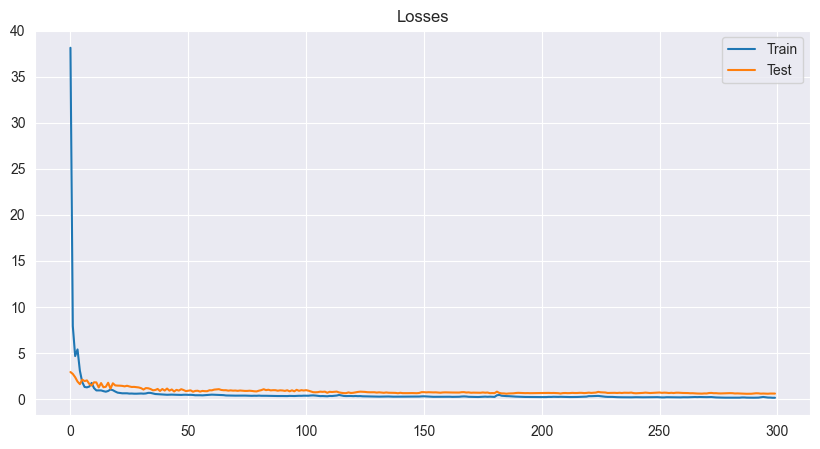

In [49]:
# calculate errors
suic_erros = []
anx_erros = []
with torch.no_grad():
    for data, y_true in suic_dataset:
        y_pred = suic_model(data)
        error = torch.abs(y_pred - y_true).item()
        suic_erros.append(error)
    for data, y_true in anx_dataset:
        y_pred = anx_model(data)
        error = torch.abs(y_pred - y_true).item()
        anx_erros.append(error)

suic_erros = np.array(suic_erros)
anx_erros = np.array(anx_erros)

# add errors to the dataframe   
df_suic_with_errors = df_suic.copy()
df_suic_with_errors["Suicidio_error"] = suic_erros
df_suic_with_errors["Ansiedade_error"] = anx_erros

# create the causal dataset with the errors
targets_idx = [df_suic_with_errors.columns.get_loc(c) for c in targets]
causal_dataset_error = CausalDataset(df_suic_with_errors.values, targets_idx)
sample_x, sample_y = causal_dataset_error[0]

# create the counterfactual model
cf_model = CounterfactualModel(sample_x.shape[0], 64, sample_y.shape[0])

# train the counterfactual model
cf_model, cf_metrics = trainPipeline(causal_dataset_error, cf_model, verbose=False, max_epochs=300, weight_decay=1e-5)

# plot the losses 
plt.figure(figsize=(10, 5))
plt.plot(cf_metrics["train_loss"], label="Train")
plt.plot(cf_metrics["test_loss"], label="Test") 
plt.title("Losses")
plt.legend()
plt.show()


In [50]:
df_suic_with_errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3953 entries, 0 to 3952
Data columns (total 70 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sexo                                     3953 non-null   float64
 1   Estado_civil                             3953 non-null   float64
 2   Status_empl                              3953 non-null   float64
 3   Licenca                                  3953 non-null   float64
 4   Tipo_Resid                               3953 non-null   float64
 5   Residencia                               3953 non-null   float64
 6   Alcoolatra                               3953 non-null   float64
 7   Droga                                    3953 non-null   float64
 8   Suic_familia                             3953 non-null   float64
 9   Dep_familia                              3953 non-null   float64
 10  Bip_familia                              3953 no

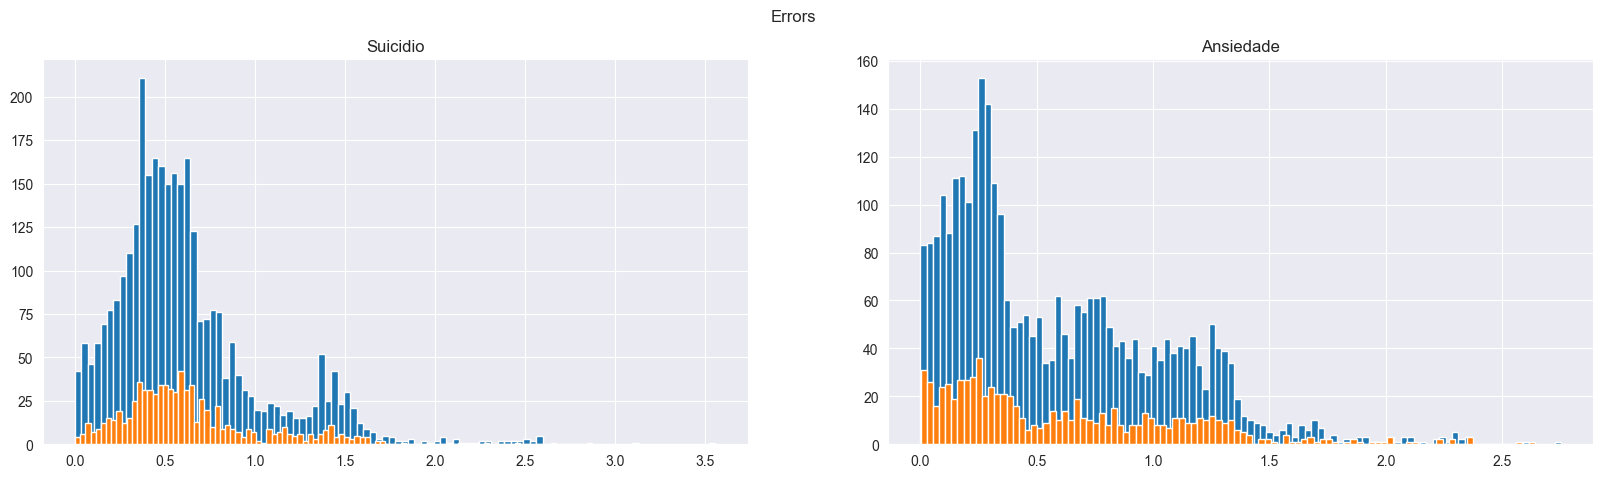

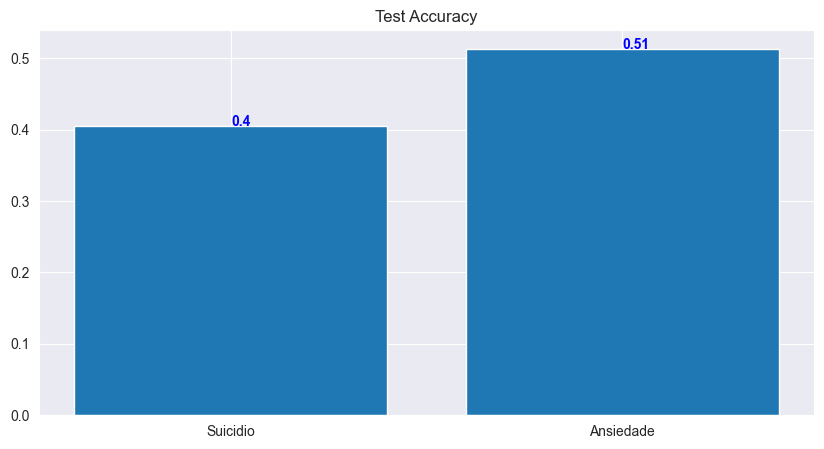

In [51]:
# plot the errors 
n_targets = len(targets)
fig, axs = plt.subplots(1, n_targets, figsize=(20, 5))
fig.suptitle("Errors")
for i in range(n_targets):
    axs[i].hist(cf_metrics["train_error"][:,i], label="Train", bins=100)
    axs[i].hist(cf_metrics["test_error"][:,i], label="Test", bins=100)
    axs[i].set_title(targets[i])
plt.show()

# plot cf_metrics['test_accuracy'] bars with target names
plt.figure(figsize=(10, 5))
plt.bar(targets, cf_metrics["test_accuracy"])
plt.title("Test Accuracy")
# add the values to the bars
for i, v in enumerate(cf_metrics["test_accuracy"]):
    plt.text(i, v, str(round(v.item(), 2)), color='blue', fontweight='bold')
plt.show()


# Now we are going to redo everything, but with the NOTEAR features

  0%|          | 0/1000 [00:00<?, ?it/s]

Final Train accuracy: [tensor(0.4877)]
Final Test accuracy: [tensor(0.4147)]


  0%|          | 0/1000 [00:00<?, ?it/s]

Final Train accuracy: [tensor(0.5373)]
Final Test accuracy: [tensor(0.4665)]


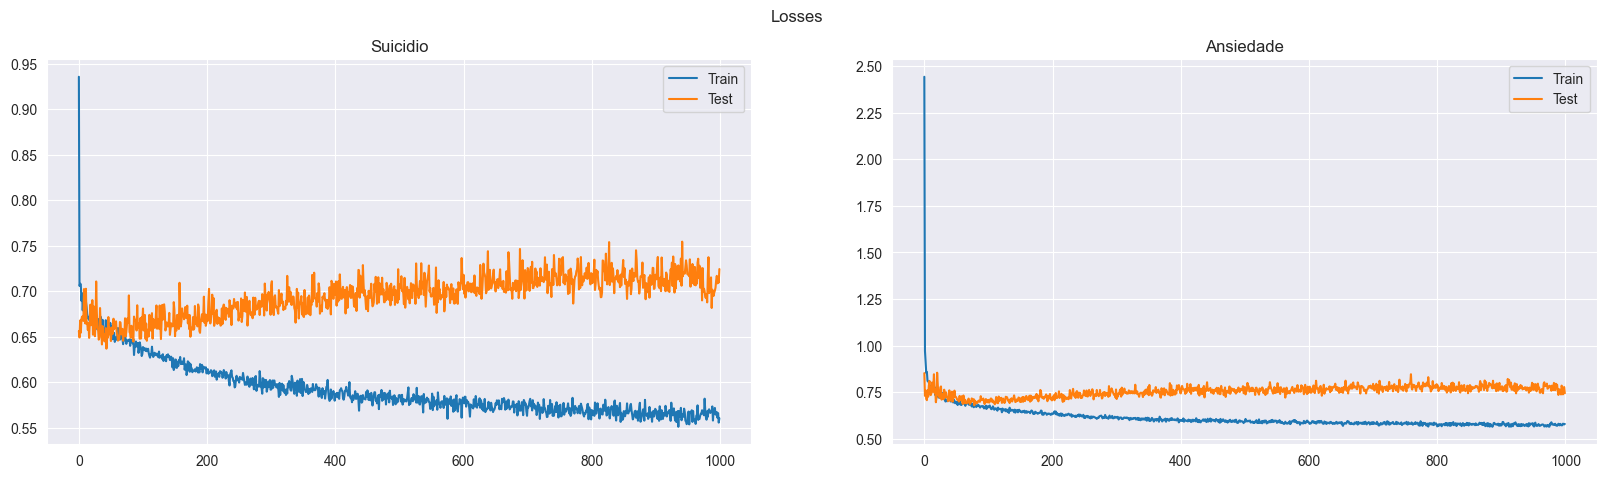

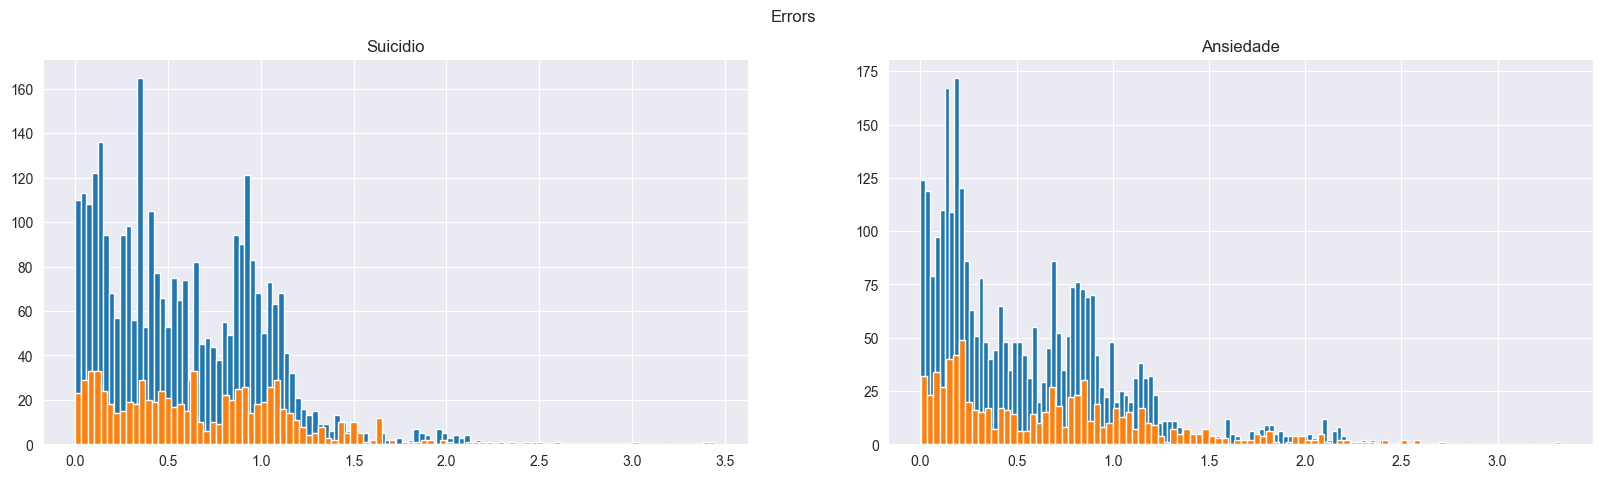

In [52]:
df_suic_notears = df_suic.copy()
df_suic_notears = df_suic_notears[notears_selected]
#notears_selected.append(['Suicidio_error','Ansiedade_error']) #todo

# create models for each target
targets = ["Suicidio", "Ansiedade"]
targets_idx = [df_suic_notears.columns.get_loc(c) for c in targets]

# Create the dataset
notears_suic_dataset = CausalDataset(df_suic_notears.values, targets_idx[0])
notears_anx_dataset = CausalDataset(df_suic_notears.values, targets_idx[1])
sample_x, sample_y = notears_suic_dataset[0]

# Now we predict the targets with a MLP
suic_causal_model = MLP([sample_x.shape[0], 64, 64, 64, 1], add_dropout=True)
anx_causal_model = MLP([sample_x.shape[0], 64, 64, 64, 1], add_dropout=True)

suic_causal_model, suic_causal_metrics = trainPipeline(notears_suic_dataset, suic_causal_model, verbose=False, max_epochs=1000, weight_decay=1e-5)
anx_causal_model, anx_causal_metrics = trainPipeline(notears_anx_dataset, anx_causal_model, verbose=False, max_epochs=1000, weight_decay=1e-5)

# plot the losses with subplots todo
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Losses")
axs[0].plot(suic_causal_metrics["train_loss"], label="Train")
axs[0].plot(suic_causal_metrics["test_loss"], label="Test")
axs[0].set_title("Suicidio")
axs[0].legend()

axs[1].plot(anx_causal_metrics["train_loss"], label="Train")
axs[1].plot(anx_causal_metrics["test_loss"], label="Test")
axs[1].set_title("Ansiedade")
axs[1].legend()

plt.show()

#  plot errors hist with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Errors")
axs[0].hist(suic_causal_metrics["train_error"][:,0], label="Train", bins=100)
axs[0].hist(suic_causal_metrics["test_error"][:,0], label="Test", bins=100)
axs[0].set_title("Suicidio")

axs[1].hist(anx_causal_metrics["train_error"][:,0], label="Train", bins=100)
axs[1].hist(anx_causal_metrics["test_error"][:,0], label="Test", bins=100)
axs[1].set_title("Ansiedade")

plt.show()

In [53]:
# calculate errors
suic_causal_erros = []
anx_causal_erros = []
with torch.no_grad():
    for data, y_true in notears_suic_dataset:
        y_pred = suic_causal_model(data)
        error = torch.abs(y_pred - y_true).item()
        suic_causal_erros.append(error)
    for data, y_true in notears_anx_dataset:
        y_pred = anx_causal_model(data)
        error = torch.abs(y_pred - y_true).item()
        anx_causal_erros.append(error)

suic_causal_erros = np.array(suic_causal_erros)
anx_causal_erros = np.array(anx_causal_erros)

# add errors to the dataframe   
df_suic_notears_with_errors = df_suic_notears.copy()
df_suic_notears_with_errors["Suicidio_error"] = suic_causal_erros 
df_suic_notears_with_errors["Ansiedade_error"] = anx_causal_erros

# create the causal dataset with the errors
targets_idx = [df_suic_notears_with_errors.columns.get_loc(c) for c in targets]
notears_causal_dataset_error = CausalDataset(df_suic_notears_with_errors.values, targets_idx)
sample_x, sample_y = notears_causal_dataset_error[0]

# create the counterfactual model
causal_cf_model = CounterfactualModel(sample_x.shape[0], 64, sample_y.shape[0])

# train the counterfactual model
causal_cf_model, causal_cf_metrics = trainPipeline(notears_causal_dataset_error, causal_cf_model, verbose=False, max_epochs=1000, weight_decay=1e-5)


  0%|          | 0/1000 [00:00<?, ?it/s]

Final Train accuracy: [tensor(0.6822), tensor(0.6293)]
Final Test accuracy: [tensor(0.6549), tensor(0.6144)]


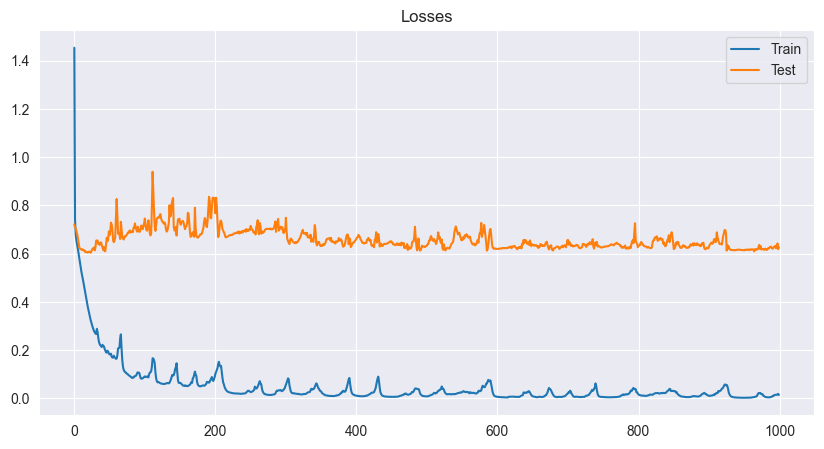

In [54]:
# plot the losses todo
plt.figure(figsize=(10, 5))
plt.plot(causal_cf_metrics["train_loss"], label="Train")
plt.plot(causal_cf_metrics["test_loss"], label="Test")
plt.title("Losses")
plt.legend()
plt.show()


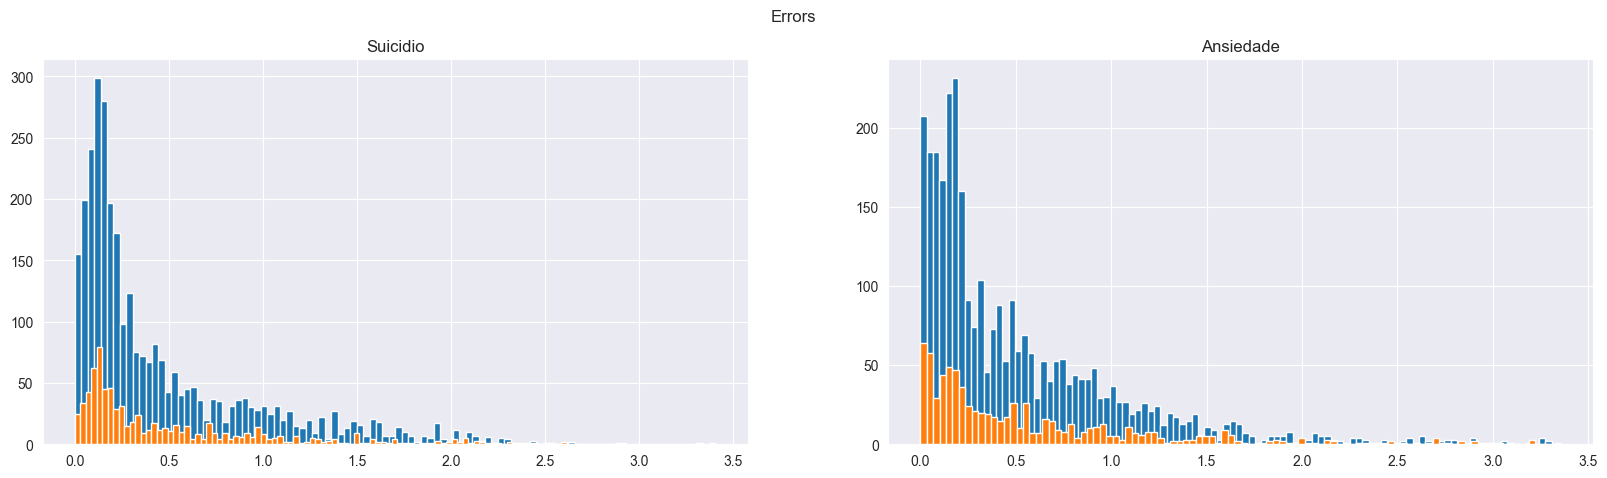

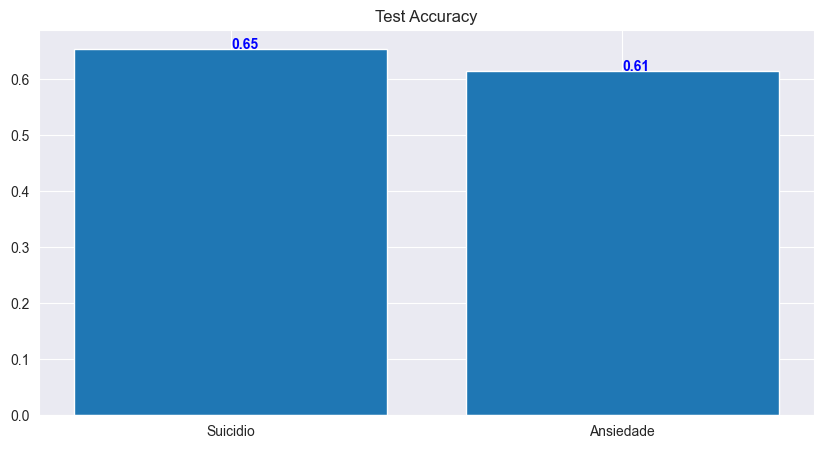

In [55]:
# plot the errors todo
n_targets = len(targets)
fig, axs = plt.subplots(1, n_targets, figsize=(20, 5))
fig.suptitle("Errors")
for i in range(n_targets):
    axs[i].hist(causal_cf_metrics["train_error"][:,i], label="Train", bins=100)
    axs[i].hist(causal_cf_metrics["test_error"][:,i], label="Test", bins=100)
    axs[i].set_title(targets[i])
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(targets, causal_cf_metrics["test_accuracy"])
plt.title("Test Accuracy")
# add the values to the bars
for i, v in enumerate(causal_cf_metrics["test_accuracy"]):
    plt.text(i, v, str(round(v.item(), 2)), color='blue', fontweight='bold')
plt.show()



In [56]:
'''!mkdir cf_models

# save everything
torch.save(causal_cf_model, "cf_models/causal_cf_model.pt")
torch.save(causal_cf_metrics, "cf_models/causal_cf_metrics.pt")

torch.save(suic_causal_model, "cf_models/suic_causal_model.pt")
torch.save(suic_causal_metrics, "cf_models/suic_causal_metrics.pt")

torch.save(anx_causal_model, "cf_models/anx_causal_model.pt")
torch.save(anx_causal_metrics, "cf_models/anx_causal_metrics.pt")

# save the non causal models also
torch.save(cf_model, "cf_models/cf_model.pt")
torch.save(cf_metrics, "cf_models/cf_metrics.pt")


torch.save(suic_metrics, "cf_models/suic_metrics.pt")

torch.save(anx_model, "cf_models/anx_model.pt")
torch.save(anx_metrics, "cf_models/anx_metrics.pt")

# save the dataframes
df_suic.to_csv("cf_models/df_suic.csv", index=False)
df_suic_with_errors.to_csv("cf_models/df_suic_with_errors.csv", index=False)

df_suic_notears_with_errors.to_csv("cf_models/df_suic_notears_with_errors.csv", index=False)
df_suic_notears.to_csv("cf_models/df_suic_notears.csv", index=False)'''

'!mkdir cf_models\n\n# save everything\ntorch.save(causal_cf_model, "cf_models/causal_cf_model.pt")\ntorch.save(causal_cf_metrics, "cf_models/causal_cf_metrics.pt")\n\ntorch.save(suic_causal_model, "cf_models/suic_causal_model.pt")\ntorch.save(suic_causal_metrics, "cf_models/suic_causal_metrics.pt")\n\ntorch.save(anx_causal_model, "cf_models/anx_causal_model.pt")\ntorch.save(anx_causal_metrics, "cf_models/anx_causal_metrics.pt")\n\n# save the non causal models also\ntorch.save(cf_model, "cf_models/cf_model.pt")\ntorch.save(cf_metrics, "cf_models/cf_metrics.pt")\n\n\ntorch.save(suic_metrics, "cf_models/suic_metrics.pt")\n\ntorch.save(anx_model, "cf_models/anx_model.pt")\ntorch.save(anx_metrics, "cf_models/anx_metrics.pt")\n\n# save the dataframes\ndf_suic.to_csv("cf_models/df_suic.csv", index=False)\ndf_suic_with_errors.to_csv("cf_models/df_suic_with_errors.csv", index=False)\n\ndf_suic_notears_with_errors.to_csv("cf_models/df_suic_notears_with_errors.csv", index=False)\ndf_suic_notears

In [57]:
df_suic_with_errors.to_csv("cf_models/df_suic_with_errors_teste.csv", index=False)

In [58]:
df_suic_notears_with_errors.to_csv("cf_models/df_suic_notears_with_errors_teste.csv", index=False)

In [59]:
torch.save(suic_causal_model, "cf_models/suic_causal_model_teste.pt")
torch.save(suic_causal_metrics, "cf_models/suic_causal_metrics_teste.pt")

# Couterfacting

In [60]:
# Load the dataset
targets = ["Suicidio", "Ansiedade"]
df = df_suic_notears_with_errors.copy # todo pd.read_csv("cf_models/df_suic_notears_with_errors.csv")
# print available columns
# print possible values for each column
for col in df.columns:
    if "error" not in col:
        print(f"{col}: {sorted(df[col].unique())}")

# load models
counterfact = causal_cf_model.pt #todo torch.load("cf_models/causal_cf_model.pt") 
counterfact = counterfact.eval()

AttributeError: 'function' object has no attribute 'columns'

In [ ]:
#df = pd.read_csv("cf_models/df_suic_notears_with_errors.csv")
targets = ["Suicidio", "Ansiedade"]

## First train one model for each target and get errors value

In [ ]:
df_test = df
cf_data = CausalDataset(df_test.values, [df_test.columns.get_loc(c) for c in targets])

# predict the counterfactuals
with torch.no_grad():
    new_cf = []
    for data, y_true in cf_data:
        data = data.unsqueeze(0)
        i = counterfact.individuality(data)        
        #data[0, cf_idx] = 0
        cf = counterfact.counterfactual(data, i)
        cf = cf.squeeze(0).round().numpy().tolist()
        new_cf.append(cf)

    new_cf = np.array(new_cf)

df_test["Ansiedade_cf"] = new_cf[:, 0]
df_test["Suicidio_cf"] = new_cf[:, 1]

#print("Counterfact individuals to remove Suic_familia")
df_test[['Ansiedade', 'Ansiedade_cf', 'Suicidio', 'Suicidio_cf']]

In [ ]:
df_test

In [ ]:
cf_data = CausalDataset(df_test.values, [df_test.columns.get_loc(c) for c in targets])

# predict the counterfactuals
with torch.no_grad():
    new_cf = []
    for data, y_true in cf_data:
        data = data.unsqueeze(0)
        i = counterfact.individuality(data)        
        #data[0, cf_idx] = 0
        cf = counterfact.counterfactual(data, i)
        cf = cf.squeeze(0).round().numpy().tolist()
        new_cf.append(cf)

    new_cf = np.array(new_cf)

df_test["Ansiedade_cf"] = new_cf[:, 0]
df_test["Suicidio_cf"] = new_cf[:, 1]

#print("Counterfact individuals to remove Suic_familia")
df_test[['Ansiedade', 'Ansiedade_cf', 'Suicidio', 'Suicidio_cf']]

In [ ]:
### SIMULANDO ALTERAÇÕES NAS FEATURES
df = pd.read_csv("cf_models/df_suic_notears_with_errors.csv")
targets = ["Suicidio", "Ansiedade"]

In [ ]:
# Select two individuals (763,1907)---random individuals
dataset = CausalDataset(df.values, [df.columns.get_loc(c) for c in targets])
#idx = np.random.choice(df.index, 2, replace=False)
idx = [763,1907]

data1, y1 = dataset[idx[0]]
data2, y2 = dataset[idx[1]]

# predict the counterfactuals for crossed individuals
with torch.no_grad():
    i1 = counterfact.individuality(data1.unsqueeze(0))
    i2 = counterfact.individuality(data2.unsqueeze(0))

    cf11 = counterfact.counterfactual(data1.unsqueeze(0), i1)
    cf12 = counterfact.counterfactual(data2.unsqueeze(0), i2)

    print("Counterfactuals for individual 1")
    print(f"Individuality: {i1.item()}, {i2.item()}")
    print(f"Counterfactual 1: {cf11.squeeze(0).round().numpy().tolist()}")
    print(f"Counterfactual 2: {cf12.squeeze(0).round().numpy().tolist()}")
    print()
